# Diffusion
OK, this is the big step up to diffusion. We are going to need to rethink our approach to produce coherence from noise.

In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import numpy as np

import matplotlib.pyplot as plt

import math

from tqdm import tqdm

In [5]:
import sys
sys.path.append('..')
from diffusion_models import utils

DATA_PATH = '../data/'
train_loader, test_loader = utils.get_mnist(32, DATA_PATH)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Variance schedule
First implement our beta scheduler. It is a fine art choosing the correct schedule.

In [6]:
T = 150 # number of time steps
start = 0.0001 # starting variance
end = 0.03 # final variance

beta = torch.linspace(start, end, T).to(device)

In [7]:
sample_image, target, label = next(iter(train_loader))
sample_image = sample_image[0]

To generate noise at a specific variance, we can use the following formula:

$$
x_t = \sqrt{1 - \beta_t}x_{t-1} + \sqrt{\beta_t}\epsilon_t
$$

But of course we have to do this iteratively

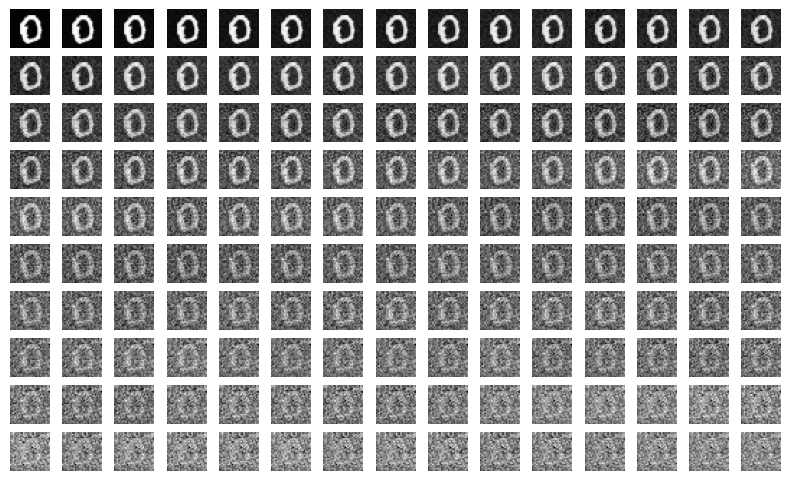

In [16]:
plt.figure(figsize=(10,6))
x_0 = sample_image[0]
x_t = x_0

for t in range(T):
    noise = torch.randn_like(x_t)
    x_t = torch.sqrt(1 - beta[t]) * x_t + torch.sqrt(beta[t]) * noise
    img = torch.squeeze(x_t).numpy()
    plt.subplot(10, 15, t+1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
plt.show()
    

Now we define a new variable $\alpha$ the cumulative product, $\bar{\alpha}$, and to make things easier, we also need to define $\sqrt{\bar{\alpha}}$ and $\sqrt{1-\bar{\alpha}}$

In [17]:
alpha = 1. - beta
alpha_bar = torch.cumprod(alpha, dim=0)
sqrt_alpha_bar = torch.sqrt(alpha_bar)
sqrt_one_minus_alpha_bar = torch.sqrt(1 - alpha_bar)

## Forward diffusion
If you remember, the forward diffusion process can be written as:

$$
x_t = \sqrt{\bar{\alpha}_t}x_0 + \sqrt{1-\bar{\alpha}_t}\epsilon
$$

where $\epsilon \sim N(0, 1)$.

In [37]:
def q(x_0, t):
    t = t.int()
    noise = torch.randn_like(x_0)
    sqrt_a_bar_t = sqrt_alpha_bar[t, None, None, None]
    sqrt_one_minus_a_bar_t = sqrt_one_minus_alpha_bar[t, None, None, None]

    x_t = sqrt_a_bar_t * x_0 + sqrt_one_minus_a_bar_t * noise
    return x_t, noise

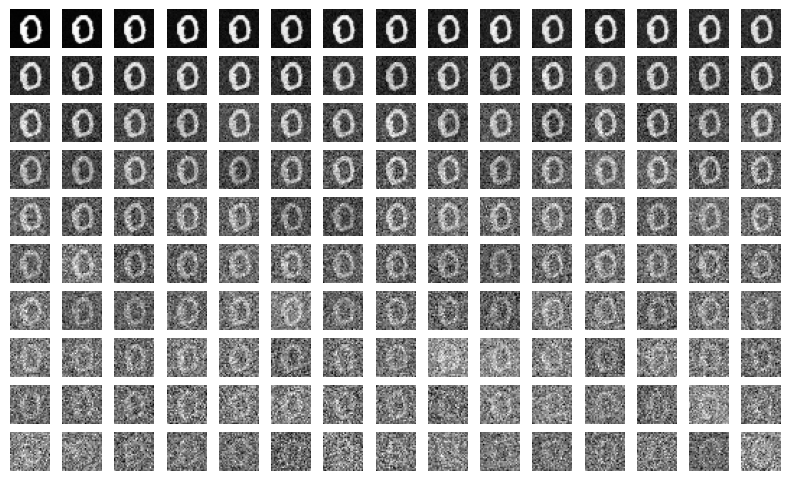

In [20]:
plt.figure(figsize=(10,6))
x_0 = sample_image[0]

for t in range(T):
    x_t = q(x_0, torch.tensor(t))[0]
    img = torch.squeeze(x_t).numpy()
    plt.subplot(10, 15, t+1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
plt.show()

Great so it's basically the same

# Loss function and conditional U-Net
We define a loss function that finds the MSE between the noise predicted by the model, and the total noise (i.e. pure noise).

In [38]:
def loss_function(model, x_0, t, label):
    x_noisy, noise = q(x_0, t)
    noise_pred = model(x_noisy, t, label)
    return F.mse_loss(noise, noise_pred)

We also add a way for the model to take in the time, and the context, in the same way as before. Only this time, we also include an additional sinusoidal encoding of the time as well. So we have a positional embedding, and a learned embedding.

In [45]:
class SinusoidBlock(nn.Module):
    def __init__(self, embedding_dim):
        super().__init__()
        self.embedding_dim = embedding_dim

    def forward(self, time):
        device = time.device
        half = self.embedding_dim // 2
        embeddings = math.log(10000) / (half - 1)
        embeddings = torch.exp(torch.arange(half, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings


class TimeBlock(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.in_features = in_features
        layers = [
            nn.Linear(in_features=in_features, out_features=out_features),
            nn.ReLU(),
            nn.Linear(in_features=out_features, out_features=out_features),
            nn.Unflatten(dim=1, unflattened_size=(out_features, 1, 1)),

        ]
        self.model = nn.Sequential(*layers)

    def forward(self, input):
        input = input.view(-1, self.in_features)
        return self.model(input)


class ContextBlock(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.in_features = in_features
        layers = [
            nn.Linear(in_features=in_features, out_features=out_features),
            nn.ReLU(),
            nn.Linear(in_features=out_features, out_features=out_features),
            nn.Unflatten(dim=1, unflattened_size=(out_features, 1, 1))
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, input):
        input = input.view(-1, self.in_features)
        return self.model(input)


class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(num_features=out_channels)
        self.pool1 = nn.MaxPool2d(kernel_size=2)

    def forward(self, x):
        x1 = F.relu(self.bn1(self.conv1(x)))
        x2 = self.pool1(x1)
        return x1, x2
    

class UpBlock(nn.Module):
    def __init__(self, in_channels, residual_channels, out_channels):
        super().__init__()

        self.upconv1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv1 = nn.Conv2d(in_channels=in_channels + residual_channels, out_channels=out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(num_features=out_channels)
        # self.conv2 = nn.Conv2d(in_channels=8, out_channels=out_channels//2, kernel_size=3, padding=1)


    def forward(self, x1, residual):
        x3 = self.upconv1(x1)
        x3 = torch.cat([x3, residual], dim=1)
        x4 = F.relu(self.bn1(self.conv1(x3)))
        return x4
            

class UNetSmol(nn.Module):
    def __init__(self, input_channels=1, output_channels=1):
        super().__init__()

        # Encoder
        self.down1 = DownBlock(in_channels=input_channels, out_channels=16)
        self.down2 = DownBlock(in_channels=16, out_channels=32)

        # Bottleneck
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(num_features=64)

        # Decoder
        self.up1 = UpBlock(in_channels=64, residual_channels=32, out_channels=32)
        self.up2 = UpBlock(in_channels=32, residual_channels=16, out_channels=16)
        self.conv6 = nn.Conv2d(in_channels=16, out_channels=output_channels, kernel_size=1)

        # combined with bottlenect output
        self.time_embedder = SinusoidBlock(embedding_dim=32)
        self.time_embedder_1 = TimeBlock(in_features=32, out_features=64)
        self.time_embedder_2 = TimeBlock(in_features=32, out_features=32)
        self.label_encoder_1 = ContextBlock(in_features=10, out_features=64)
        self.label_encoder_2 = ContextBlock(in_features=10, out_features=32)


    def forward(self, x, t, labels=None):
        # Down
        x1, x2 = self.down1(x)
        x3, x4 = self.down2(x2)

        # Bottleneck
        x5 = F.relu(self.bn3(self.conv3(x4)))

        # Up
        t = self.time_embedder(t)
        time_embedding_1 = self.time_embedder_1(t)

        label_embedding_1 = self.label_encoder_1(labels)
        x5 = label_embedding_1 * x5 + time_embedding_1
        
        x6 = self.up1(x5, x3)

        time_embedding_2 = self.time_embedder_2(t)
        label_embedding_2 = self.label_encoder_2(labels)
        x6 = label_embedding_2 * x6 + time_embedding_2

        x7 = self.up2(x6, x1)
        

        x8 = self.conv6(x7)
        return x8

In [46]:
model = UNetSmol(1, 1)
optimizer = optim.AdamW(model.parameters(), lr=0.001)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [47]:
sample_image, target, label = next(iter(train_loader))
loss = loss_function(model, sample_image, torch.tensor(0).unsqueeze(0), label)

In [ ]:
num_epochs = 10

losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for sample_image, target, label in tqdm(train_loader):
        sample_image = sample_image.to(device)
        target = target.to(device)
        label = label.to(device)
        optimizer.zero_grad()
        t = torch.randint(0, T, (32,), device=device)
        # t = t.float()
        loss = loss_function(model, sample_image, t, label)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        losses.append(loss.item())

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')


## Sampling

In [49]:
sqrt_a_inv = torch.sqrt(1 / alpha)
pred_noise_coeff = (1 - alpha) / torch.sqrt(1 - alpha_bar)

In [50]:
@torch.no_grad()
def reverse_q(x_t, t, epsilon_t):
    t = torch.squeeze(t[0].int())
    pred_noise_coeff_t = pred_noise_coeff[t]
    sqrt_a_inv_t = sqrt_a_inv[t]
    u_t = sqrt_a_inv_t * (x_t - pred_noise_coeff_t * epsilon_t)
    if t == 0:
        return u_t
    else:
        beta_t = beta[t-1]
        new_noise = torch.randn_like(x_t)
        return u_t + torch.sqrt(beta_t) * new_noise

In [48]:
# save model
torch.save(model.state_dict(), 'model_bigger.pth')

In [53]:
@torch.no_grad()
def sample_images(number=1):
    x_t = torch.randn(1, 1, 28, 28, device=device)
    label = torch.zeros(1, 10, device=device)
    label[0, number] = 1
    x_ts = []
    for i in tqdm(range(0, T)[::-1]):
        t = torch.full((1,), i, device=device)
        t = t.float()
        e_t = model(x_t, t, label)
        x_t = reverse_q(x_t, t, e_t)
        x_ts.append(x_t)

    return x_ts

100%|██████████| 150/150 [00:00<00:00, 492.00it/s]


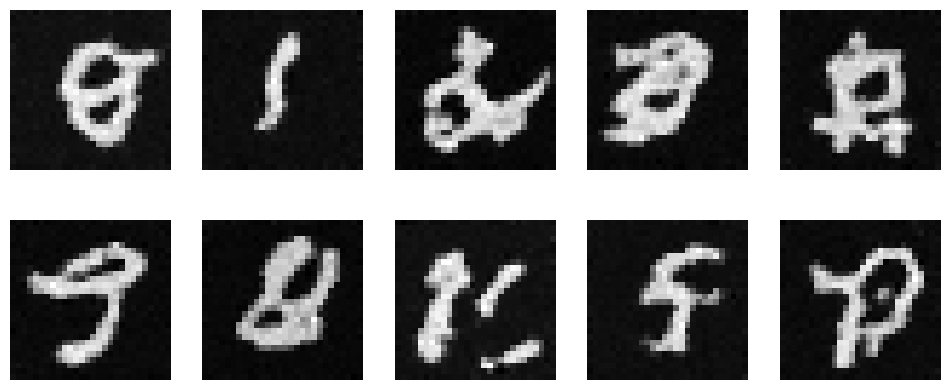

In [56]:
plt.figure(figsize=(12, 5))
model.eval()
for i in range(10):
    x_t = sample_images(number=i)[-1]
    img = torch.squeeze(input=x_t).cpu()
    ax = plt.subplot(2, 5, i + 1)
    ax.axis('off')
    plt.imshow(img, cmap='gray')


So we stopped things short, but this isn't terrible...OK, it's terrible. Let's abstract out some of this code, and try again...